In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# %cd ..
# %rm -r mamba4rec-11-02-2024
# %cp -r /kaggle/input/mamba4rec-11-02-2024 ./
# %cd mamba4rec-11-02-2024

In [16]:
# %mkdir dataset
# %mkdir saved

In [ ]:
# !pip install recbole ray mamba-ssm kmeans-pytorch

In [5]:
# %ls /kaggle/input/checkpoint-beauty/pytorch/default/1

In [6]:
# %cp /kaggle/input/checkpoint-beauty/pytorch/default/1/checkpoint_beauty_2.pth saved/

## Mamba4Rec training on amazon-beauty

In [18]:
import sys
import os
import logging
import argparse
from logging import getLogger
from recbole.utils import init_logger, init_seed
from recbole.trainer import Trainer
from mamba4rec import Mamba4Rec
# from mamba4rec_attr import Mamba4Rec
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.data.transform import construct_transform
from recbole.utils import (
    init_logger,
    get_model,
    get_trainer,
    init_seed,
    set_color,
    get_flops,
    get_environment,
)

args = {
    "config_file": "config_beauty.yaml",
    "checkpoint_file": "saved/checkpoint.pth"#"saved/Mamba4Rec-Nov-04-2024_07-14-15.pth"
}
config = Config(model=Mamba4Rec, config_file_list=[args["config_file"]], config_dict={
    "show_progress": False
})
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()
logger.info(sys.argv)
logger.info(config)

# dataset filtering
dataset = create_dataset(config)
logger.info(dataset)

# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

# model loading and initialization
init_seed(config["seed"] + config["local_rank"], config["reproducibility"])
model = Mamba4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

transform = construct_transform(config)
flops = get_flops(model, dataset, config["device"], logger, transform)
logger.info(set_color("FLOPs", "blue") + f": {flops}")

# trainer loading and initialization
trainer = Trainer(config, model)


if os.path.exists(args["checkpoint_file"]):
    trainer.resume_checkpoint(args["checkpoint_file"])
# model training
best_valid_score, best_valid_result = trainer.fit(
    train_data, valid_data, show_progress=config["show_progress"]
    # saved=True, verbose=True
)

# trainer.eval_collector.data_collect(train_data)
# model evaluation
test_result = trainer.evaluate(
    test_data, show_progress=config["show_progress"]
)

environment_tb = get_environment(config)
print(
    "The running environment of this training is as follows:\n"
    + environment_tb.draw()
)

print(set_color("best valid ", "yellow") + f": {best_valid_result}")
print(set_color("test result", "yellow") + f": {test_result}")

The running environment of this training is as follows:
+-------------+----------------+
| Environment |     Usage      |
+=============+================+
| CPU         |    16.50 %     |
+-------------+----------------+
| GPU         | 2.35 G/14.74 G |
+-------------+----------------+
| Memory      | 2.05 G/31.36 G |
+-------------+----------------+
best valid : OrderedDict([('hit@10', 0.0944), ('ndcg@10', 0.0566), ('mrr@10', 0.0451)])
test result: OrderedDict([('hit@10', 0.0739), ('ndcg@10', 0.0436), ('mrr@10', 0.0344)])


## Analyze model performance

In [19]:
import pandas as pd
import numpy as np
import torch

In [20]:
beauty_item = pd.read_csv("dataset/amazon-beauty/amazon-beauty.item", delimiter="\t")
beauty_inter = pd.read_csv("dataset/amazon-beauty/amazon-beauty.inter", delimiter="\t")

#### Retrieve valid users and items only (with at least 5 interactions)

In [21]:
valid_users = dataset.id2token(dataset.uid_field, range(dataset.user_num))[1:]
valid_items = dataset.id2token(dataset.iid_field, range(dataset.item_num))[1:]

In [22]:
valid_df = beauty_inter[
    (beauty_inter["user_id:token"].isin(pd.Series(valid_users))) & 
    (beauty_inter["item_id:token"].isin(pd.Series(valid_items)))
]
len(valid_df)

198502

In [23]:
print(f"Number of items: {beauty_item['item_id:token'].nunique()}")
print(f"Number of items in interaction: {beauty_inter['item_id:token'].nunique()}")
print(f"Number of valid items: {valid_df['item_id:token'].nunique()}")

Number of items: 259204
Number of items in interaction: 249274
Number of valid items: 12101


#### Demo: Recommend for a user with 50 interactions

In [24]:
def make_prediction(item_token_ids_list, k):
    interaction = {
        "item_id_list": torch.LongTensor(item_token_ids_list).to("cuda"),
        "item_length": torch.LongTensor([len(x) for x in item_token_ids_list]).to("cuda")
    }
    scores = model.full_sort_predict(interaction)
    _, sort_inds = torch.sort(scores, descending=True)
    sort_inds = sort_inds.to("cpu")
    topk = dataset.id2token(dataset.iid_field, sort_inds[:,:k])
    return topk, sort_inds

def rank(sort_inds, item_token):
    item_id = dataset.token2id(dataset.iid_field, item_token)
    r = np.where(sort_inds == item_id)[0][0]
    return r
    # print(f"Rank of next item: {rank}, fall within top{rank / (dataset.item_num-1) * 100 : .2f}%.")

In [25]:
test_uid = valid_df.groupby("user_id:token").filter(lambda x: len(x) == 50)["user_id:token"].iloc[0]
test_seq = valid_df[valid_df["user_id:token"] == test_uid]
test_seq = test_seq.sort_values(by="timestamp:float", ascending=True)
token_ids = dataset.token2id(dataset.iid_field, test_seq["item_id:token"][:-1].tolist())
top10, sort_inds = make_prediction(token_ids.reshape(1,-1), 10)

In [26]:
item_seq = test_seq["item_id:token"]
print("Most recent item sequence:")
titles = beauty_item[beauty_item["item_id:token"].isin(item_seq[:-1])]["title:token"].tolist()
for title in titles[-10:]:
    print(f"- {title[:50]}")

Most recent item sequence:
- Ellen Tracy Daytime Moisturizer Size Morning Moist
- Cetaphil Gentle Skin Cleansing Cloths, 25 Count
- ORGANIC Argan Oil 4OZ &#9733;SALE&#9733; 100% PURE
- Dove Pure Care Dry Oil Conditioner, 12 Ounce
- Clear Scalp and Hair Intense Hydration Nourishing 
- Clear Scalp and Hair Intense Hydration Nourishing 
- Vitamin C Serum For Face 20% &#9733;Weekend SALE&#
- 4oz Organic Rosehip Oil &#9733; BIG 4 OUNCE! &#973
- Moroccan Rose Water 100% Pure &amp; Natural For Fa
- Organic Rosehip Oil 4OZ &#9733;SALE&#9733; 100% Pu


In [27]:
next_item_token = item_seq.iloc[-1]
next_item_title = beauty_item[beauty_item["item_id:token"] == next_item_token]["title:token"]
print(f"Next item: {next_item_title}")
print("Top 10 recommended item:")
top10_titles = beauty_item[beauty_item['item_id:token'].isin(pd.Series(top10[0]))]["title:token"]
for title in top10_titles:
    print(f"- {title[:50]}")

Next item: 242559    Fekkai Technician Color Care Conditioner 236ml...
Name: title:token, dtype: object
Top 10 recommended item:
- BEST Hyaluronic Acid Skin Serum With Vitamins C &a
- John Frieda Precision Foam Hair Color, Glosser Coo
- John Frieda Precision Foam Hair Color, Glosser Coo
- John Frieda Precision Foam Hair Color, Glosser War
- #1 PREMIUM Hyaluronic Acid Serum - 100% Pure, Undi
- Dove Oxygen Moisture Conditioner, 12 Ounce
- Dove Hair Styling Oxygen Moisture Root Lift Spray,
- Dove Hair Styling Oxygen Moisture Leave In Foam, 5
- Dove Pure Care Dry Oil Conditioner, 12 Ounce
- Suave Professionals Natural Infusion Seaweed and L


In [28]:
rank_next_item = rank(sort_inds[0], next_item_token)
print(f"Rank of next item: {rank_next_item}")

Rank of next item: 184


#### Analyze the effect of max sequence length

In [29]:
seq_lengths = [5, 10, 50, 100, 204]
mean_ranks = []
for length in seq_lengths:
    test_uids = valid_df.groupby("user_id:token").filter(lambda x: len(x) == length)["user_id:token"]
    
    test_inters = valid_df[valid_df["user_id:token"].isin(test_uids)]
    test_inters = test_inters.sort_values(by="timestamp:float", ascending=True)
    test_inters = test_inters.groupby("user_id:token").agg(list).reset_index()

    seq = test_inters["item_id:token"].tolist()
    
    test_seq = [seq[:-1] for seq in seq]
    next_items = [seq[-1] for seq in seq]

    token_ids_list = dataset.token2id(dataset.iid_field, test_seq)
    
    top10, sort_inds = make_prediction(token_ids_list, 10)
    num_items = sort_inds.shape[0]
    ranks_of_items = [rank(sort_inds[i], next_items[i]) for i in range(num_items)]
    
    mean_ranks.append(np.mean(ranks_of_items))

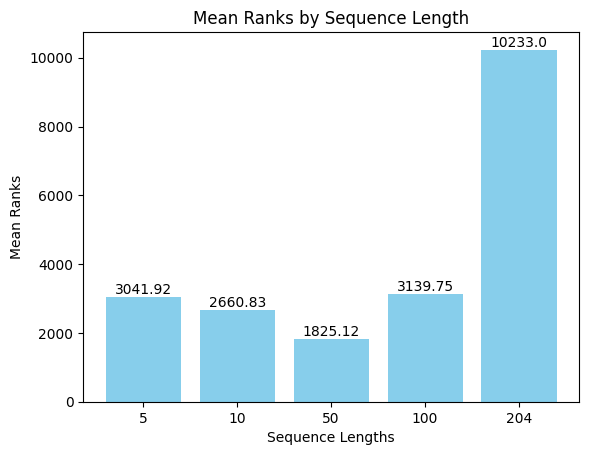

In [30]:
import matplotlib.pyplot as plt

plt.figure()
labels = [str(x) for x in seq_lengths]
bars = plt.bar(labels, mean_ranks, color='skyblue')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom')  # Adjust text position

# Labeling the axes and title
plt.xlabel('Sequence Lengths')
plt.ylabel('Mean Ranks')
plt.title('Mean Ranks by Sequence Length')
plt.xticks(labels)
plt.show()